# Notebook de Modélisation

## Introduction

## Chargement des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine

In [2]:
# Charger les variables d'environnement à partir du fichier .env
load_dotenv()

# Utiliser les variables d'environnement pour les paramètres de connexion
server = os.getenv("SERVER")
database = os.getenv("DATABASE")
user = os.getenv("AZUREUSER")
password = os.getenv("PASSWORD")

In [3]:
# Créer la chaîne de connexion
azure_connection_string = f"mssql+pyodbc://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"

# Créer le moteur SQLAlchemy
engine = create_engine(azure_connection_string)

In [4]:
df = pd.read_sql_query("SELECT * FROM CleanDataset", engine)

# Séries Temporelles

/home/utilisateur/miniconda3/envs/data_analyse/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/utilisateur/miniconda3/envs/data_analyse/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/utilisateur/miniconda3/envs/data_analyse/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Mean Squared Error: 78961.25110644629


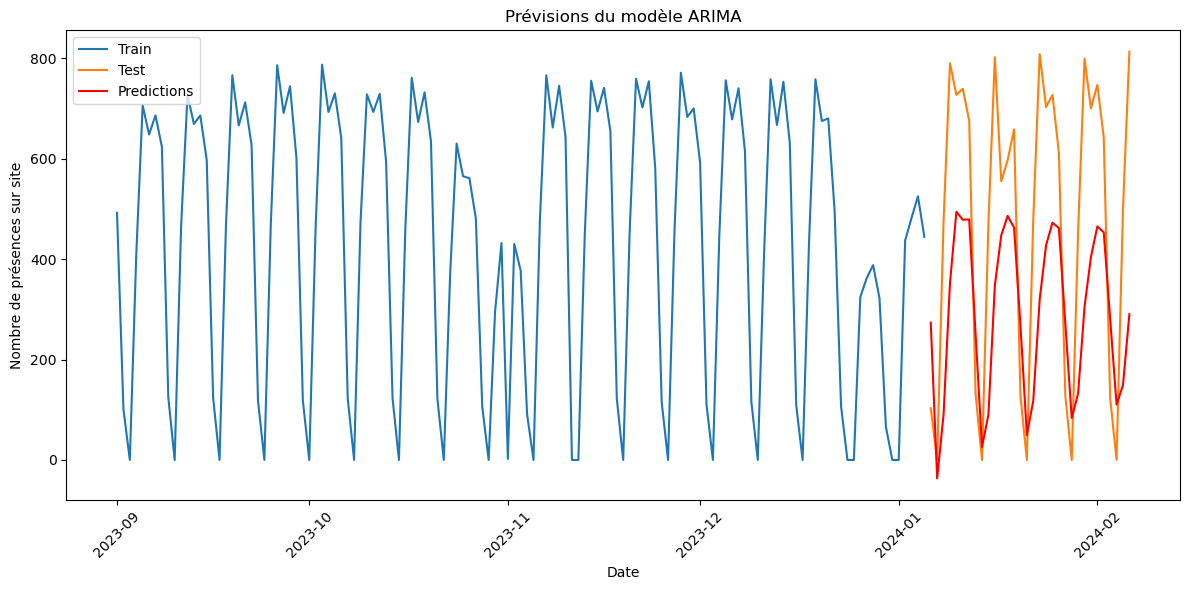

In [5]:
# Convertir la colonne 'Date' en datetime et l'utiliser comme index
df['id_jour'] = pd.to_datetime(df['id_jour'])
df.set_index('id_jour', inplace=True)

# Remplacer les valeurs manquantes par 0
df.fillna(0, inplace=True)

# Séparation des données en ensembles d'entraînement et de test
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# Ajustement du modèle ARIMA aux données d'entraînement
model = ARIMA(train_data['nb_presence_sur_site'], order=(5,1,0))
model_fit = model.fit()

# Prévisions sur les données de test
predictions = model_fit.forecast(steps=len(test_data))

# Calcul de l'erreur quadratique moyenne
mse = ((predictions - test_data['nb_presence_sur_site']) ** 2).mean()
print('Mean Squared Error:', mse)

# Visualisation des prévisions
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['nb_presence_sur_site'], label='Train')
plt.plot(test_data.index, test_data['nb_presence_sur_site'], label='Test')
plt.plot(test_data.index, predictions, label='Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Nombre de présences sur site')
plt.title('Prévisions du modèle ARIMA')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
from prophet import Prophet

/home/utilisateur/miniconda3/envs/data_analyse/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
df.reset_index('id_jour', inplace=True)

In [10]:
df_prophet = df[['id_jour', 'nb_couvert']]

In [11]:
df_prophet.rename(columns={'id_jour':'ds', 'nb_couvert':'y'}, inplace=True)

/tmp/ipykernel_1601252/381355044.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prophet.rename(columns={'id_jour':'ds', 'nb_couvert':'y'}, inplace=True)


In [12]:
m = Prophet()
m.fit(df_prophet)

11:41:10 - cmdstanpy - INFO - Chain [1] start processing
11:41:10 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
519,2025-02-01
520,2025-02-02
521,2025-02-03
522,2025-02-04
523,2025-02-05


In [14]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
519,2025-02-01,-6.695126,-52.261454,41.797951
520,2025-02-02,-6.697192,-58.861166,41.836840
521,2025-02-03,145.889922,99.966795,193.420826
522,2025-02-04,164.624835,114.133792,213.209586
523,2025-02-05,142.252981,94.033806,192.909012


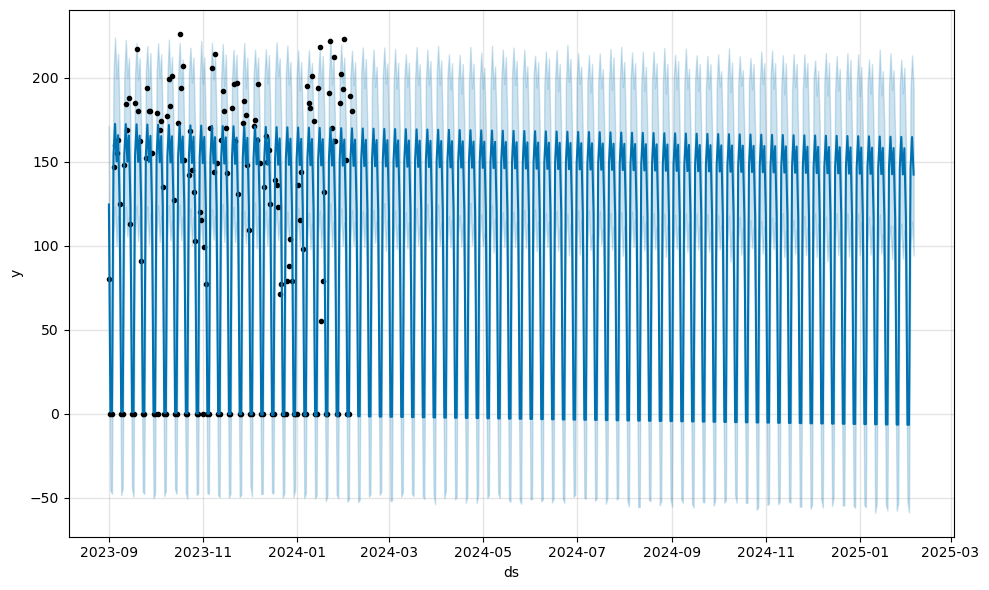

In [15]:
fig1 = m.plot(forecast)

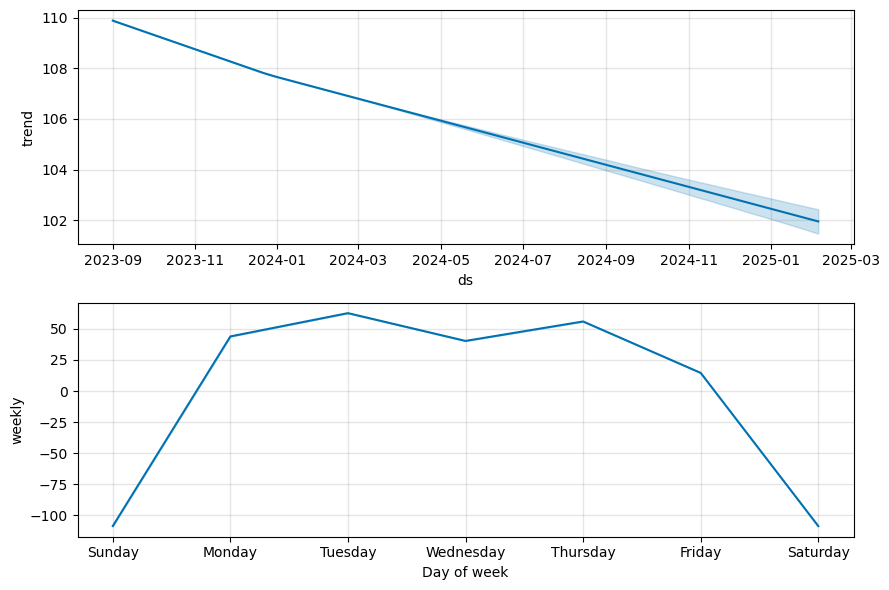

In [16]:
fig2 = m.plot_components(forecast)

# Régression Linéaire

In [17]:
# Convertir la colonne 'Date' en type datetime
df['Jour_Semaine'] = df['id_jour'].dt.day_name()

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [19]:
# Créer une colonne pour chaque type de vacances et initialiser à 0
df['Vacances_Ete_2023'] = 0
df['Vacances_Toussaint_2023'] = 0
df['Vacances_Noel_2023'] = 0

# Marquer les jours de chaque période de vacances avec la valeur 1
# Vacances d'été 2023
df.loc[(df['id_jour'] >= '2023-07-01') & (df['id_jour'] <= '2023-09-03'), 'Vacances_Ete_2023'] = 1

# Vacances de la Toussaint 2023
df.loc[(df['id_jour'] >= '2023-10-21') & (df['id_jour'] <= '2023-11-05'), 'Vacances_Toussaint_2023'] = 1

# Vacances de Noël 2023
df.loc[(df['id_jour'] >= '2023-12-23') & (df['id_jour'] <= '2024-01-07'), 'Vacances_Noel_2023'] = 1

In [20]:
# Convertir la variable catégorielle 'Jour_Semaine' en variables indicatrices
df = pd.get_dummies(df, columns=['Jour_Semaine'], drop_first=True)

In [21]:
df

,id_jour,temperature,nb_presence_sur_site,nb_couvert,Vacances_Ete_2023,Vacances_Toussaint_2023,Vacances_Noel_2023,Jour_Semaine_Monday,Jour_Semaine_Saturday,Jour_Semaine_Sunday,Jour_Semaine_Thursday,Jour_Semaine_Tuesday,Jour_Semaine_Wednesday
0,2023-09-01,21.8,492.0,80,1,0,0,False,False,False,False,False,False
1,2023-09-02,28.8,101.0,0,1,0,0,False,True,False,False,False,False
2,2023-09-03,30.0,0.0,0,1,0,0,False,False,True,False,False,False
3,2023-09-04,30.0,408.0,147,0,0,0,True,False,False,False,False,False
4,2023-09-05,31.5,706.0,160,0,0,0,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2024-02-02,7.7,642.0,151,0,0,0,False,False,False,False,False,False
155,2024-02-03,9.9,123.0,0,0,0,0,False,True,False,False,False,False
156,2024-02-04,9.7,0.0,0,0,0,0,False,False,True,False,False,False
157,2024-02-05,8.2,499.0,189,0,0,0,True,False,False,False,False,False


In [22]:
# Séparer les caractéristiques (X) de la variable cible (y)
X = df.drop(['nb_couvert', 'id_jour'], axis=1)  # Caractéristiques
y = df['nb_couvert']  # Variable cible

# Diviser les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser et entraîner le modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Calculer l'erreur quadratique moyenne (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

# Afficher les coefficients du modèle
print("Coefficients:", model.coef_)

# Afficher l'intercept du modèle
print("Intercept:", model.intercept_)

RMSE: 13.552519880396417
Coefficients: [ 0.10197965  0.30051176 -3.74219716 11.49404601 11.5684553  82.85573739
 18.81643171 52.27020204 14.07961326  6.18060544 12.85821892]
Intercept: -55.427692119983575


In [23]:
# Calculer le score sur l'ensemble de test
score = model.score(X_test, y_test)
print("Score R² sur l'ensemble de test:", score)

Score R² sur l'ensemble de test: 0.9717344231167212


In [24]:
# Modifier le format d'affichage des nombres à virgule flottante
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [25]:
# Créer un DataFrame avec les valeurs réelles et prédites
predictions = pd.DataFrame({'Reelles': y_test, 'Predites': y_pred})

# Concaténer les colonnes pertinentes avec les valeurs réelles et prédites
df_results_with_features = pd.concat([df[['id_jour', 'nb_presence_sur_site', 'nb_couvert']], predictions], axis=1)

# Obtenir l'index des données de test
test_index = X_test.index

# Filtrer le DataFrame des résultats pour ne garder que les occurrences du jeu de test
df_results_test = df_results_with_features.loc[test_index]

df_results_test.sort_values(by='id_jour')

,id_jour,nb_presence_sur_site,nb_couvert,Reelles,Predites
9,2023-09-10,0.000,0,0.000,0.147
12,2023-09-13,669.000,169,169.000,160.482
15,2023-09-16,124.000,0,0.000,3.273
16,2023-09-17,0.000,0,0.000,-0.577
18,2023-09-19,766.000,217,217.000,182.903
19,2023-09-20,666.000,180,180.000,159.988
24,2023-09-25,469.000,152,152.000,170.673
29,2023-09-30,119.000,0,0.000,1.301
30,2023-10-01,0.000,0,0.000,-0.588
31,2023-10-02,465.000,179,179.000,169.838


In [26]:
df

,id_jour,temperature,nb_presence_sur_site,nb_couvert,Vacances_Ete_2023,Vacances_Toussaint_2023,Vacances_Noel_2023,Jour_Semaine_Monday,Jour_Semaine_Saturday,Jour_Semaine_Sunday,Jour_Semaine_Thursday,Jour_Semaine_Tuesday,Jour_Semaine_Wednesday
0,2023-09-01,21.800,492.000,80,1,0,0,False,False,False,False,False,False
1,2023-09-02,28.800,101.000,0,1,0,0,False,True,False,False,False,False
2,2023-09-03,30.000,0.000,0,1,0,0,False,False,True,False,False,False
3,2023-09-04,30.000,408.000,147,0,0,0,True,False,False,False,False,False
4,2023-09-05,31.500,706.000,160,0,0,0,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2024-02-02,7.700,642.000,151,0,0,0,False,False,False,False,False,False
155,2024-02-03,9.900,123.000,0,0,0,0,False,True,False,False,False,False
156,2024-02-04,9.700,0.000,0,0,0,0,False,False,True,False,False,False
157,2024-02-05,8.200,499.000,189,0,0,0,True,False,False,False,False,False
